In [1]:
!pip install --user tqdm
# 진행상태 가시화를 위한 tqdm 라이브러리 사용


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip show tqdm

Name: tqdm
Version: 4.66.6
Summary: Fast, Extensible Progress Meter
Home-page: https://tqdm.github.io
Author: 
Author-email: 
License: MPL-2.0 AND MIT
Location: C:\Users\sshyu\AppData\Roaming\Python\Python312\site-packages
Requires: colorama
Required-by: 


In [3]:
!pip install ipywidgets


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip show opencv-python

Name: opencv-python
Version: 4.10.0.84
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: C:\Users\sshyu\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: numpy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## **1. LeNet -5**

In [5]:
import tqdm

In [7]:
# 필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # 이미지 변환 기능 제공
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

In [8]:
# 데이터셋의 전처리 
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                # 이미지ㅇ를 변형할 수 있는 방식들의 묶음
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                # 입력미이지를 주어진 크기로 조정 
                # scale은 원래 이미지를 임의의 크기 50-100% 만큼 면적을 무작위로 자름
                transforms.RandomHorizontalFlip(),
                # 주어진 확률로 이미지 수평 반전시킴
                # default 값은 0.5
                # 훈련데이터 이미지의 반은 위아래 뒤집힌 상태로 두고
                # 나머지 반은 그대로 사용
                transforms.ToTensor(),
                # PIL로 이미지를 읽으면 생성되는 이미지의 범위는 [0,255]
                # 픽셀범위가 [0,1]로, 차원순서가 CHW 순서로 바꿔줌
                transforms.Normalize(mean, std)
                # 정규화 진행
                # RGB 채널마다 평균과 표준편차 사용
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        # 클래스 호출할 수 있도록 하는 매서드
        return self.data_transform[phase](img)

In [21]:
# 이미지 데이터셋을 불러온 후 훈련, 검증 테스트 로 분리
cat_directory="C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Cat/"
dog_directory="C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Dog/"

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
# 데이터를 정렬된 리스트로 만들어서 반환
# os.path.join을 사용해서 cat directory와 os.listdir을 통해 검색된 이미지 파일들을 합치기
# 반복문을 통해 가져운 데이터에 i를 이요해서 이미지로 만들어줌
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    
correct_images_filepaths = [i for i in images_filepaths]    
# 반복문 통해 images_filepaths에서 이미지 데이터 검색
# if 조건문 통해 모든 이미지 데이터 읽어오기
random.seed(42)    
# 임의의 난수 생성
# 시드값을 부여하여 상태가 저장됨
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400] 
val_images_filepaths = correct_images_filepaths[400:-10]  
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [54]:
test_images_filepaths 

['C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Cat/cat.145.jpg',
 'C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Dog/dog.211.jpg',
 'C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Cat/cat.162.jpg',
 'C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Cat/cat.200.jpg',
 'C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Cat/cat.210.jpg',
 'C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Cat/cat.224.jpg',
 'C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Dog/dog.213.jpg',
 'C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Cat/cat.109.jpg',
 'C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Cat/cat.15.jpg',
 'C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/Dog/dog.167.jpg']

In [89]:
# 테스트 데이터셋의 이미지 확인함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 입력이미지, 변환할 이미지 색성 지정
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        # 이미지 전체 경로를 정규화학 분할을 위한 코드
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

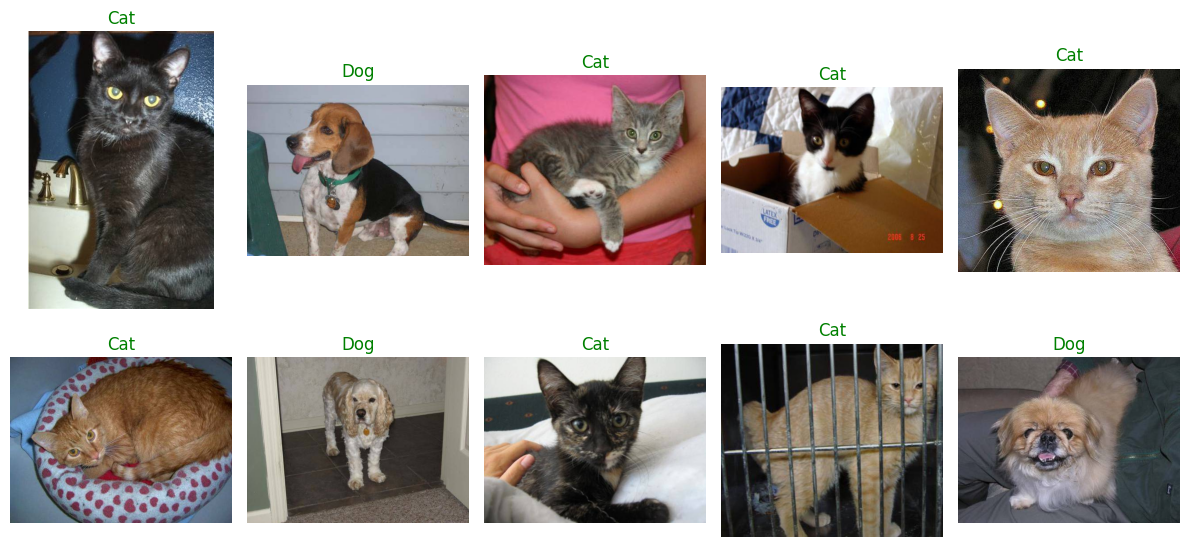

In [70]:
# 테스트 데이터셋의 이미지 확인 함수
def display_image_grid2(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols + (len(images_filepaths) % cols > 0)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    
    for i, image_filepath in enumerate(images_filepaths):
        # 파일 경로를 유니코드로 인코딩하여 읽기
        image = cv2.imdecode(np.fromfile(image_filepath, dtype=np.uint8), cv2.IMREAD_COLOR)

        # 이미지가 제대로 로드되지 않았을 경우 처리
        if image is None:
            print(f"Error: Could not read image at {image_filepath}")
            continue

        # 이미지 색상 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 레이블 추출 및 시각화
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    
    plt.tight_layout()
    plt.show()

# 예시로 호출
display_image_grid2(test_images_filepaths)

In [71]:
for filepath in test_images_filepaths:
    if not os.path.exists(filepath):
        print(f"File does not exist: {filepath}")

In [76]:
# 이미지 데이터셋 클래스 정의
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        # 이미지 데이터셋의 전체 길이를 반환
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):       
        # 데이터셋에서 데이터를 가져오는 부분으로 결과는 텐서형태
        img_path = self.file_list[idx]
        # img_path 위치에서 이미지 데이터를 가져옴
        # 이미지에 train 전처리를 적용
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        # 이미지 전체 경로에서 /를 제거, .을 제거
        # 따라서 dog.113.jpg에서 [0]번째 인덱스인 dog를 가져
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [77]:
# 변수값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [78]:
# 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
# 훈련데이터의 크기 출력
print(train_dataset.__getitem__(index)[0].size())
# 훈련 데이터의 레이블 출
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [79]:
# 데이터 로더 정의
# pytorch의 dataloader는 배치 관리를 담당함. 한번에 모든 데이터를 불러오면 메모리에 부담을 줄 수 있기 때문
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# 여기서는 batchsize 32개씩 데이터를 가져옴
# shuffle=True를 통해 임의로 섞어서 데이터를 가져옴
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1])


In [80]:
# 데이터를 학습시킬 모델의 네트워크 설계 클래스 생성 
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 2d 합성곱층이 적용되어 입력형태는 3,224,224 이고 출력 형태는 16,220,220
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        self.relu1 = nn.ReLU() 
        # 활성화함수 relu사용
        # maxpooling 이후 출력 형태는 16,110,110
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # 다시 2d 합성곱층 적용
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) 
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)         
        self.fc1 = nn.Linear(32*53*53, 512) 
        self.relu5 = nn.ReLU()         
        self.fc2 = nn.Linear(512, 2) 
        self.output = nn.Softmax(dim=1)        
    
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out) 
        out = self.relu2(out) 
        out = self.maxpool2(out)
        # 완전 연결층에 데이터 전달하기 위해 데이터 형태 1차원으로 바기
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out)                    
        out = self.output(out)
        return out

In [82]:
# 모델 객체 생성
model = LeNet()
# 출력기
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [83]:
# 네트워크 관련 정보 확인
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [84]:
# 모델에서 학습 가능한 파라미터 수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [85]:
# 옵티마이저 손실 함수 정의
# 경사하강법으로  모멘텀 SGD 사용.
# 모멘텀 SGD란 SGD에 관성이 추가되어 매번 기울기를 구하지만 가중치를 수정하기 전에 
# 이전 수정방향을 참고하여 같은 방향으로 일정한 비율만 수정되게 하는 방식
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [86]:
# 모델의 모든 파리미터 및 손실함수가 GPU를 사용할 수 있도록
# 여기서는 CPU 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [87]:
# 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    # 여기서는 10번 반복
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:           
            if phase == 'train':
                model.train() # 모델 학습
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device) # 훈련 데이터셋을 CPU에 할당
                labels = labels.to(device)
                optimizer.zero_grad() # 역전파 단계 실행하기 전 기울기를 0으로 초기화
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) # 손실 함수 이요한 오차 계산
                    
                    if phase == 'train':
                        loss.backward() # 모델에 학습 가능한 모든 파라미터에 대해 기울기 계산
                        optimizer.step() # step 함수 통해 파라미터 갱신
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    # 정답과 예측이 일치하면 그것의 합계를 epoch_corrects에 계산
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            # 최종 정확도 계싼
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # 검증 데이터셋에 대한 가장 최적의 정확도 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [48]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\sshyu\AppData\Local\Temp\ipykernel_6948\3689613115.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6966 Acc: 0.4800


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7010 Acc: 0.4457
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6842 Acc: 0.5625


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7153 Acc: 0.5000
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6812 Acc: 0.5575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7104 Acc: 0.4783
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6706 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.5761
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6639 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7053 Acc: 0.5000
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6660 Acc: 0.5975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6954 Acc: 0.5000
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6523 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6872 Acc: 0.5761
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6457 Acc: 0.6375


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6872 Acc: 0.5978
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6615 Acc: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7015 Acc: 0.5435
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6543 Acc: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6935 Acc: 0.5109
Training complete in 7m 38s
Best val Acc: 0.597826


In [90]:
# 모델 테스트 위한 함수 정의
import pandas as pd
id_list = []
pred_list = []
_id=0
# 역전파 중 텐서에 대한 변화도를 계산할 필요가 없기 때문
# 훈련 데이터셋 모델학습과 가장 큰 차이점
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

# 데이터 프레임은 csv 파일로 저장
res.to_csv("C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/LeNet", index=False)

C:\Users\sshyu\AppData\Local\Temp\ipykernel_6948\1392545748.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [91]:
res.head(10)

,id,label
0,109,0.502198
1,145,0.498632
2,15,0.501369
3,162,0.500509
4,167,0.488136
5,200,0.507332
6,210,0.497889
7,211,0.501776
8,213,0.494088
9,224,0.514783


In [96]:
# 테스트 데이터 이미지 출력하기 위한 함수 정의
# 개와 고양이에 대한 클래스 정의
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols + (len(images_filepaths) % cols > 0)  # 행 계산 보완
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    
    for i, image_filepath in enumerate(images_filepaths):
        # 파일을 유니코드로 인코딩하여 읽기
        image = cv2.imdecode(np.fromfile(image_filepath, dtype=np.uint8), cv2.IMREAD_COLOR)
        
        # 이미지가 제대로 로드되지 않았을 경우 처리
        if image is None:
            print(f"Error: Could not read image at {image_filepath}")
            continue

        # 이미지 색상 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 랜덤 레이블 생성 및 설정
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        label = 1 if label > 0.5 else 0
        
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    
    plt.tight_layout()
    plt.show()

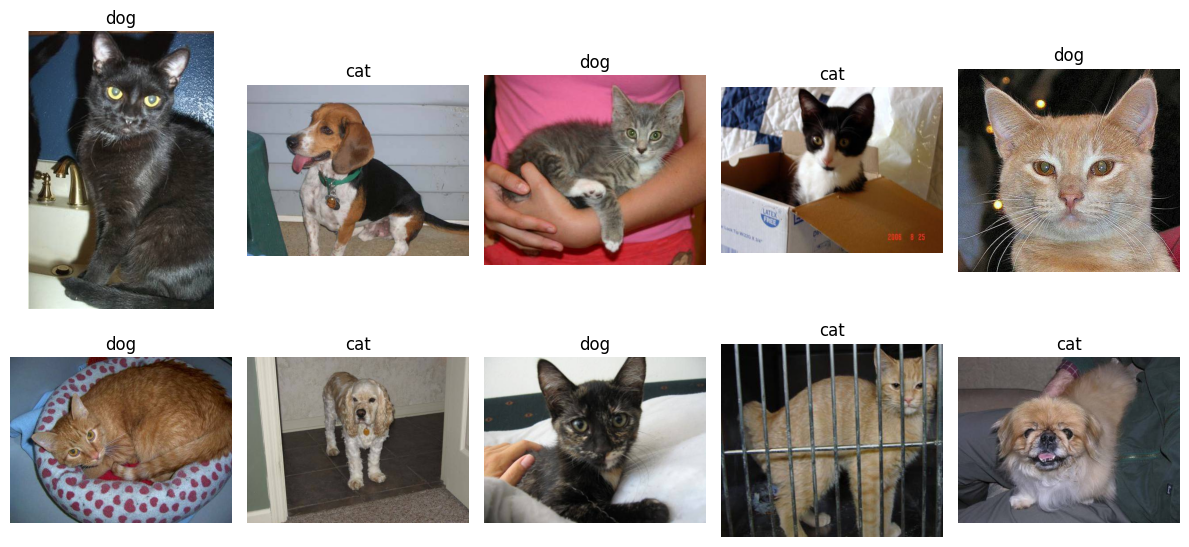

In [97]:
display_image_grid(test_images_filepaths) 

## **6.1.3. AlexNet**

In [100]:
# 커스텀 데이터셋 정의
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [101]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
# 이때 전처리도 함께 적용
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

In [103]:
# 데이터셋을 메모리로 불러오기
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0])


In [104]:
# AlexNet 모델 네트워크 정
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # AvgPool2d는 풀링을 위해 사용됨
        # 따라서 풀링에 대한 커널 및 스트라이드 크기를 정의해야 동작함
        # Adaptive는 풀링 작업이 끝날 때 필요한 출력 크기를 정의함
        # 출력에 대한 크기만 지정하기 때문에 조정이 상당히 쉬워짐
        # 입력 크기에 변동이 있고 CNN 위에 완전 연결층을 사용하는 경우 유용
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [105]:
# 모델 객체 생
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [106]:
# 학습에 사용될 옵티마이저와 손실함수를 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [107]:
# 모델 구조 네트워크 확
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [108]:
# 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
   
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [109]:
# 모델 학
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\sshyu\AppData\Local\Temp\ipykernel_6948\585654950.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6936 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.4891
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6936 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6937 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6935 Acc: 0.4891
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6935 Acc: 0.4875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5217
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5761
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5109
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6926 Acc: 0.5400


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5217
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5435
Training complete in 18m 11s


In [111]:
# 모델 이용한 예
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths): # 테스트 이미지 이용
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1] # 이미지 데이터 번호 가져기
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val') # 테스트 데이터에 검증용 전처리 적용
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv("C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/dogs-vs-cats/alexnet", index=False)

C:\Users\sshyu\AppData\Local\Temp\ipykernel_6948\1876603295.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths): # 테스트 이미지 이용


  0%|          | 0/10 [00:00<?, ?it/s]

In [112]:
# 데이터 프레임에 대한 결과 확인
res.head(10)

,id,label
0,145,0.499459
1,211,0.499066
2,162,0.499356
3,200,0.501786
4,210,0.501223
5,224,0.499233
6,213,0.499146
7,109,0.500445
8,15,0.500033
9,167,0.499429


In [113]:
class_ = classes = {0:'cat', 1:'dog'}
# 테스트 데이터셋의 이미지 확인 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols + (len(images_filepaths) % cols > 0)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    
    for i, image_filepath in enumerate(images_filepaths):
        # 파일 경로를 유니코드로 인코딩하여 읽기
        image = cv2.imdecode(np.fromfile(image_filepath, dtype=np.uint8), cv2.IMREAD_COLOR)

        # 이미지가 제대로 로드되지 않았을 경우 처리
        if image is None:
            print(f"Error: Could not read image at {image_filepath}")
            continue

        # 이미지 색상 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 레이블 추출 및 시각화
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    
    plt.tight_layout()
    plt.show()

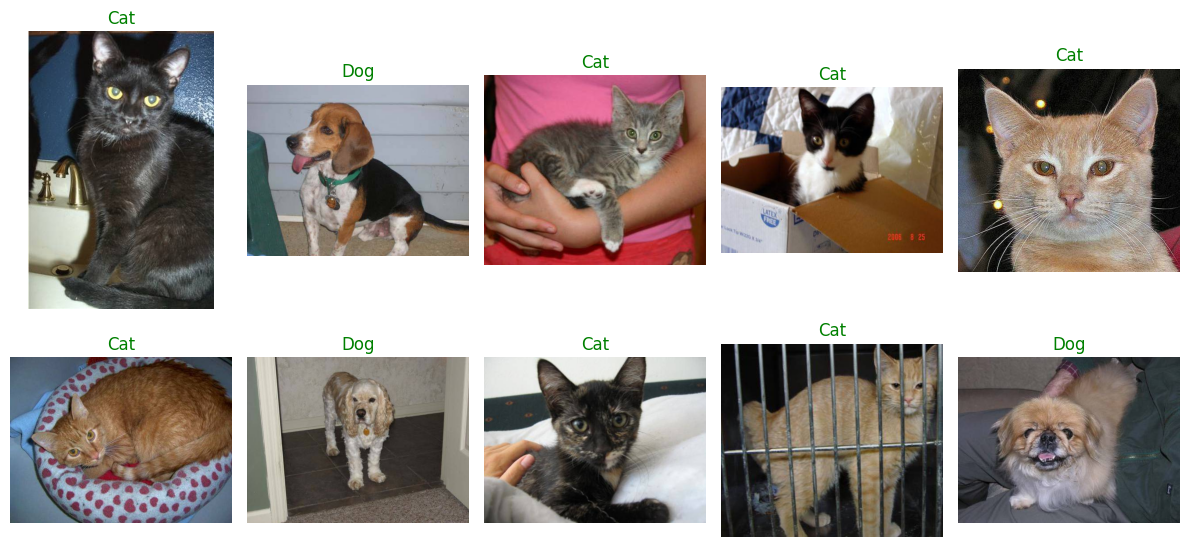

In [114]:
# 예측결과에 대한 이미지와 함께 출력
display_image_grid(test_images_filepaths) 

## **6.1.3. VGGNet**

### VGG 11 구현

In [116]:
# 필요한 라이브러리 호출
import copy
# 객체 복사를 위해 사용됨
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

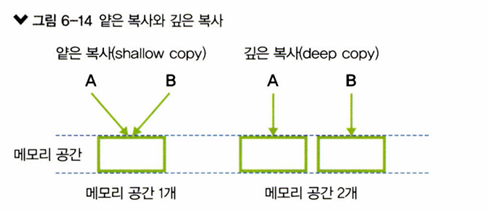

In [117]:
# VGG 모델 정의
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        # 매개변수에서 가져온 features 값을 넣
        self.features = features        
        self.avgpool = nn.AdaptiveAvgPool2d(7)        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [119]:
# 모델 유형 정의
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']

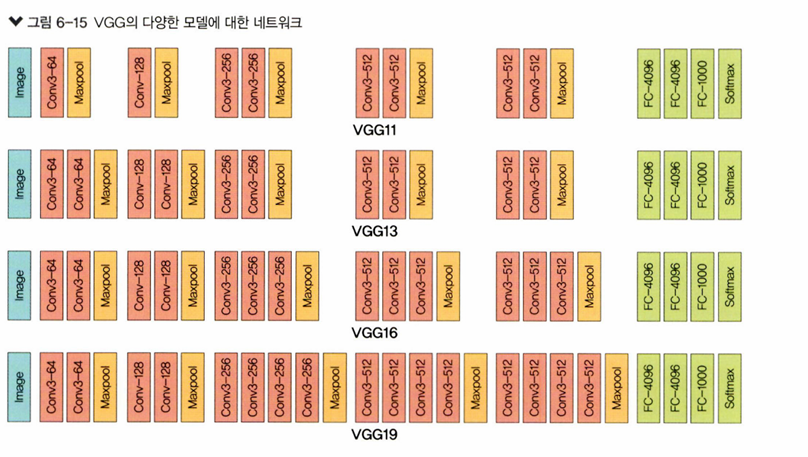

In [120]:
# 각 모델에 대한 네트워크
# VGG 계층 정
def get_vgg_layers(config, batch_norm):    
    layers = []
    in_channels = 3
    
    for c in config: # vgg11 config값들을 가져옴
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            # 불러온 값이 M이면 maxpooling을 적용
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            # 불러온 값이 숫자면 합성곱 적용
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                # 배치 정규화를 적용할지에 대한 코드
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
                # 배치 정규화가 적용될 경우 배치 정규화 + ReLU 적용
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
                # 배치 정규화가 적용되지 않을 경우 ReLU만 적용
            in_channels = c
            
    return nn.Sequential(*layers)
    # 네트워크의 모든 계층을 반환

In [121]:
# 모델 계층 생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

In [122]:
# 모델 계층 확인
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [123]:
# 모델 전체에 대한 네트워크 확인
OUTPUT_DIM = 2
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [124]:
# VGG는 사전훈련된 모델로 이미 누군가가 대용량의 이미지 데이터로 학습시켰으며
# 최상의 상태로 튜닝을 거쳐 모든 사람이 사용할 수 있도록 공유함
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained = True)
print(pretrained_model)

C:\Users\sshyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sshyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to C:\Users\sshyu/.cache\torch\hub\checkpoints\vgg11_bn-6002323d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 507M/507M [00:08<00:00, 63.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [126]:
# 이미지 데이터 전처리
train_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                            # 5도 이하로 이미지를 회전시킴
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [128]:
train_path="C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/catanddog/train"
test_path="C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/catanddog/test"
train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

529
12


(None, None)

In [129]:
# 훈련 검증 데이터 분할
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO)
n_valid_examples = len(train_dataset) - n_train_examples

train_data, valid_data = data.random_split(train_dataset, 
                                           [n_train_examples, n_valid_examples])

In [130]:
# 검증 데이터 전처리
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [131]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [132]:
# 메모리로 데이터 불러기
BATCH_SIZE = 128
train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 # 훈련 데이터는 섞어서 가져옴
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset, 
                                batch_size = BATCH_SIZE)

In [133]:
# 모델 학습에 사용될 옵티마이저와 손실함수 정의
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [135]:
# 모델 정확도 측정 함수 정의
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    # view_as를 통해 텐서 크기를 사용할 것이라는 것
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [136]:
# 훈련 데이터세 이용할 모델 학습 함수 정의=
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()                
        y_pred, _ = model(x)        
        loss = criterion(y_pred, y)       
        acc = calculate_accuracy(y_pred, y)        
        loss.backward()        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [137]:
# 모델 성능 측정 함수 정의
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [138]:
# 학습 시간 측정 함수 정의
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# 모델 학습
EPOCHS = 2
best_valid_loss = float('inf')
for epoch in range(EPOCHS):    
    start_time = time.monotonic()    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),"C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/VGG-model.pt")

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 21m 19s
	Train Loss: 0.710 | Train Acc: 48.45%
	 Valid. Loss: 0.693 |  Valid. Acc: 58.49%
Epoch: 02 | Epoch Time: 21m 31s
	Train Loss: 0.703 | Train Acc: 50.48%
	 Valid. Loss: 0.693 |  Valid. Acc: 58.49%


In [ ]:
# 테스트 데이터셋을 이용한 모델 성능 측정
model.load_state_dict(torch.load("C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/VGG-model.pt"))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
# 테스트 데이터셋을 이요한 모델의 예측 확인 함
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            # 배열에서 가장 큰 인덱스를 찾을 때 사용. 여기서는 각 열에서 가장 큰 값을 가져옴
            top_pred = y_prob.argmax(1, keepdim = True)
            # keepdim을 통해 출력 텐서의 크기를 입력과 동일한 크기로 지
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    # 텐서를 연결할 때 사용
    # dim=0을 통해 행을 기준으로 x를 이어붙
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [ ]:
# 예측 중 가장 정확하게 예측한 것을 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
# 이미지 출력을 위한 전처리
# 본래 이미지를 출력하기 위해선, 이미 앞에서 이미지의 크기 및 전처리 과정을 거쳤기 때문에
# 이 상태에서 이미지를 출력하면 안
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    # torch.add가 아닌 torch.add_를 이용하여 새로운 공간 할당 없이 
    # 기존의 메모리에 위치한 값을 대체함
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
# 모델이 정확하게 예측한 이미지만 출력하기 위한 함수 생
def plot_most_correct(correct, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)        
        image, true_label, probs = correct[i]
        # 축을 변경할 때 사용함
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

In [ ]:
# 예측 결과 이미지 출력
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)

## **6.1.6 ResNet**

In [ ]:
# 필요한 라이브러리 호출
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
# 파이썬의 자료형 중 하나로 튜플의 성질을 가지고 있지만 인덱스 뿐만 아니라 키 값으로 데이터에 접근이 가능함
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 이미지 전처리 드
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [ ]:
# 변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
# 훈련 데이터와 테스트 데이터 셋 불러오기
cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None] 

In [ ]:
# 데이터셋을 훈련 검증 테스트 용도로 분리하기
random.seed(42)    
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]    
val_images_filepaths = correct_images_filepaths[400:-10]  
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

In [ ]:
# 이미지에 대한 레이블 구분
# dog면 1, cat이면 0 여
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):       
        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [ ]:
# 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

In [ ]:
# 데이터셋의 데이터를 메모리로 불러오기
train_iterator  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

In [ ]:
# 기본 블록 정
class BasicBlock(nn.Module):    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            # 다운샘플링이 적용
            # 입력 데이터의 크기와 네트워크를 통과한 후 출력 데이터의 크기가 다를 경우 사용됨
            # 다음과 같이 합성곱층에 스트라이드를 적용하면 
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None        
        self.downsample = downsample
        
    def forward(self, x):       
        i = x       
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
        # 아이덴티티 매핑이 적용됨 특정 층에 존재하는 출력 결과를 
        # 다음 합성곱층을 통과한 출력 결과에 더해준다고 하여 skip connection이라고도 불림
        x += i
        x = self.relu(x)
        
        return x

In [ ]:
# 병목 블록 정의
class Bottleneck(nn.Module):
    # 병목 블록을 정의하기 위한 하이퍼파라미터
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()    
        # 1x1 의 합성곱층
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        # 3x3 의 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        # 1x1 합성곱층
        # 다음 계층의 입력 채널 수와 일치하도록 
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None            
        self.downsample = downsample
        
    def forward(self, x):        
        i = x        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [ ]:
# ResNet 모델 네트크크
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]   
        # 블록 크기와 채널 크기 모두 4
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        # 블록을 추가하기 위한 함수
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):   
        layers = []        
        # 다르면 downsampling 적용
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels            
        return nn.Sequential(*layers)
        
    def forward(self, x):        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)        
        return x, h

In [ ]:
# ResNetConfig 변수에 네임트 튜플 형식으로 변수 저장
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
# 기본 블록을 사용해서 ResNetConfig 정의
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [ ]:
# 병목 블록을 사용해서 정의
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [ ]:
# 사전 훈련된 모델 사용
pretrained_model = models.resnet50(pretrained = True)

In [ ]:
# 사전 훈련된 ResNet 50 네트워크 확인
print(pretrained_model)

In [ ]:
# 두개의 클래스 사용
OUTPUT_DIM = 2
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

In [ ]:
# 옵티마이저와 손실 함수 정
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# 모델이 얼마나 잘 학습되었는지 확인하기 위한 정확도 측정 함수 정의
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
# 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
            
        optimizer.zero_grad()                
        y_pred = model(x)  
        
        loss = criterion(y_pred[0], y) 
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)        
        loss.backward()        
        optimizer.step()        
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# 모델 평가 함수 정의 
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)            
            loss = criterion(y_pred[0], y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# 모델 학습 시간 측정 함수 정의
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# 모델 학
best_valid_loss = float('inf')
EPOCHS = 3

for epoch in range(EPOCHS):    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/ResNet_model.pt")

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

In [ ]:
# 테스트 데이터셋을 이요한 모델 예측 
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv("C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap06/data/ResNet.csv", index=False)
res.head(10)

In [ ]:
# 모델 예측에 대한 결과 출력 
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths) 